In [2]:
using PastaQ
using ITensors
using Plots
using StatsPlots

In [3]:
# Define our gates

function PastaQ.gate(::GateName"R"; theta::Real, phi::Real)
    [
        cos(theta/2)    (-im * exp(-im * phi) * sin(theta/2))
        (-im * exp(im * phi) * sin(theta/2))     cos(theta/2)
    ]
end

function PastaQ.gate(::GateName"M"; Theta::Real)
    [
        cos(Theta)    0    0    (-im * sin(Theta))
        0    cos(Theta)    (-im * sin(Theta))    0
        0    (-im * sin(Theta))    cos(Theta)    0
        (-im * sin(Theta))    0    0    cos(Theta)
    ]
end

function PastaQ.gate(::GateName"Z";)
    [
        1.00    0
        0     -1.00
    ]
end

function PastaQ.gate(::GateName"X";)
    [
        0    1.00
        1.00     0
    ]
end
function PastaQ.gate(::GateName"M_p"; Theta::Real, delta::Real)
    [
        cos(Theta+delta)    0    0    (-im * sin(Theta+delta))
        0    cos(Theta+delta)    (-im * sin(Theta+delta))    0
        0    (-im * sin(Theta+delta))    cos(Theta+delta)    0
        (-im * sin(Theta+delta))    0    0    cos(Theta+delta)
    ]
end

In [4]:
function run(N, depth, flipon)
    # Random circuit.
    gates = Vector{Tuple}[]
    if flipon == true
        td=rand(1:depth)
        tN=rand(1:N)
    end
    for i in 1:depth
        one_qubit_layer = Tuple[]
        two_qubit_layer = Tuple[]
        
        for j in 1:N
            gate = ("R", j, (theta=2pi*rand(), phi=2pi*rand()))
            push!(one_qubit_layer, gate)
            if flipon == true
                if j==tN && i==td
                    push!(one_qubit_layer, ("X", j))
                end
            end
        end

        # Alternate start qubit for pairs.
        idx_first = i % 2 + 1

        for j in idx_first:2:(N-1)
            gate = ("M", (j, j+1), (Theta=2pi*rand(),))
            push!(two_qubit_layer, gate)
        end
        
        push!(gates, one_qubit_layer)
        push!(gates, two_qubit_layer)
            
    end
    psi = runcircuit(N, gates)
end

run (generic function with 1 method)

In [5]:
function run_sysErr(N, depth, flipon, delta)
    # Random circuit.
    gates = Vector{Tuple}[]
    if flipon == true
        td=rand(1:depth)
        tN=rand(1:N)
    end
    for i in 1:depth
        one_qubit_layer = Tuple[]
        two_qubit_layer = Tuple[]
        
        for j in 1:N
            gate = ("R", j, (theta=2pi*rand(), phi=2pi*rand()))
            push!(one_qubit_layer, gate)
            if flipon == true
                if j==tN && i==td
                    push!(one_qubit_layer, ("X", j))
                end
            end
        end

        # Alternate start qubit for pairs.
        idx_first = i % 2 + 1

        for j in idx_first:2:(N-1)
            gate = ("M_p", (j, j+1), (Theta=2pi*rand(), delta))
            push!(two_qubit_layer, gate)
        end
        
        push!(gates, one_qubit_layer)
        push!(gates, two_qubit_layer)
            
    end
    psi = runcircuit(N, gates)
end

run_sysErr (generic function with 1 method)

In [14]:
function get_Probs(psi,N)      
    sites = siteinds("S=1/2", N)
    norm=0
    probs=zeros(0)
    for i=0:2^N-1
        x=digits(i,base=2,pad=N)
        states = [j+1 for j in x]
        phi = productMPS(ComplexF64,sites, states)
        y=inner(phi,psi)
        prob=y*conj(y)
        append!(probs,prob)
        norm=norm+prob
    end
    return probs
end        

get_Probs (generic function with 1 method)

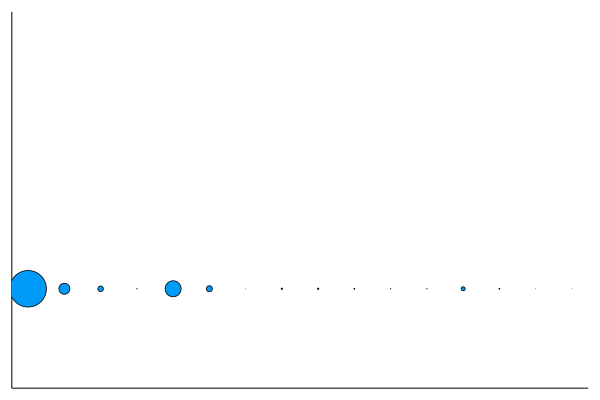

In [5]:
# TASK 1
N=4
depth=4
flipon=false #bit flip flag on or off
psi=run(N,depth,flipon)
pb=get_Probs(psi,N)

yy=zeros(0)
for i=1:length(pb)
    append!(yy,2.0)
end
# The scatter statement produces the speckle pattern graph
scatter!(yy, ms = 50*pb, ylims=[1.5,3.5], legend=false, ticks=nothing)

In [6]:
# Task 2
#this function runs the circut multiple times and calcualtes the bitstring probabilities
function runcirc_multiple(M,N,depth,flipon)
    results=Tuple[]
    for i=1:M
        psi=run(N,depth,flipon)
        push!(results,get_Probs(psi,N))
    end
    return results
end

runcirc_multiple (generic function with 1 method)

In [46]:
#Task 4
#This functions create P(xi) samples for equation #1
function run_sampling(s,N,depth,flipon,delta)
    fxeb=zeros(2^N)
    for i=1:s
        psi=run_sysErr(N,depth,flipon,delta)
        fxeb=fxeb+get_Probs(psi,N)
    end
    fxeb=(2^N)*fxeb/s .-1
    return fxeb
end

#Applying the perturbation for series of DeltaThetas between zero to 2pi with the steps 2pi/gran
function perturb(gran,s,N,depth,flipon,site)
    deltas=zeros(0)
    avg_fxeb=zeros(0)
    for x=0:pi/gran:2pi
        append!(deltas,x)
        fxeb=run_sampling(s,N,depth,flipon,x)
        append!(avg_fxeb,fxeb[site])
    end
    return deltas,avg_fxeb
end
        

perturb (generic function with 2 methods)

In [43]:
#Task 4 sample run
deltas,fxeb=perturb(50,50,4,150,false,1)

([0.0, 0.06283185307179587, 0.12566370614359174, 0.1884955592153876, 0.25132741228718347, 0.3141592653589793, 0.3769911184307752, 0.4398229715025711, 0.5026548245743669, 0.5654866776461628  …  5.6548667764616285, 5.717698629533424, 5.7805304826052195, 5.843362335677016, 5.906194188748811, 5.969026041820608, 6.031857894892403, 6.094689747964199, 6.157521601035995, 6.220353454107791], [0.2518256975862192, -0.012313992352786962, -0.13927651756429127, -0.20946474764269563, -0.17478857187054875, 0.05432600445798075, -0.041535129938908955, 0.10161774764729281, 0.03385031451269094, -0.13970362246324652  …  -0.07686096776143403, -0.18831329445524492, 0.07662549661726459, -0.25913133181146075, -0.09074505121433885, -0.11374491664928243, 0.08895550268292807, 0.14133652332260516, -0.21077970302746696, 0.07472577927514301])

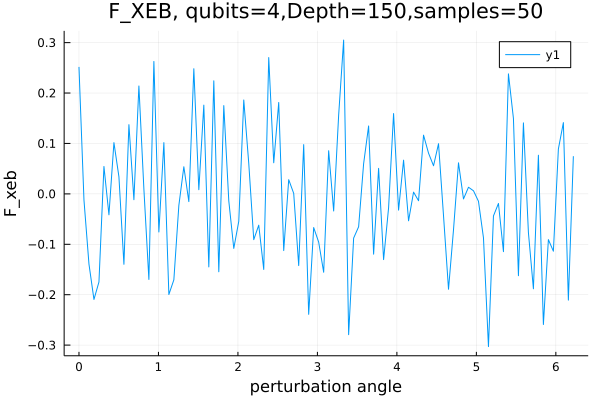

In [45]:
#Task 4 sample plot
plot(deltas,fxeb, title="F_XEB, qubits=4,Depth=150,samples=50",xlabel = "perturbation angle", ylabel = "F_xeb")

In [ ]:
#Task 4 sample run
deltas,fxeb=perturb(5,500,3,512,false,1)

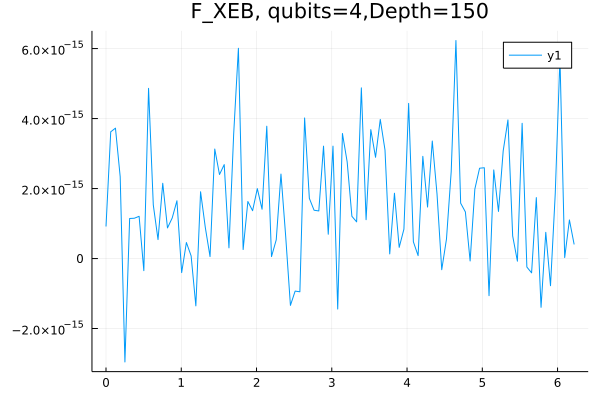

In [24]:
#Task 4 sample plot
plot(deltas,fxeb, title="F_XEB, qubits=3,Depth=512,samples=500",xlabel = "perturbation angle", ylabel = "F_xeb")